In [174]:
import pandas as pd
import yfinance as yf
import yaml
import matplotlib.pyplot as plt
from cycler import cycler
import warnings
import numpy as np
from itertools import pairwise
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [175]:
pairs = yaml.safe_load(open("../.config/strategy_params.yaml", "r"))["Pairs Trading Strategy"]["pairs"]

In [176]:
pairs_ts = {}
for pair in pairs:
    pairs_ts[tuple(pair)] = yf.download(pair, interval="1m")

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed


In [177]:
pairs = list(pairs_ts.keys())

In [178]:
for pair in pairs_ts:
    pairs_ts[pair] = pairs_ts[pair]["Adj Close"]
    pairs_ts[pair].reset_index(inplace=True)

In [179]:
for pair in pairs_ts:
    pairs_ts[pair].loc[:, "Fraction"] = pairs_ts[pair][pair[0]] / pairs_ts[pair][pair[1]]

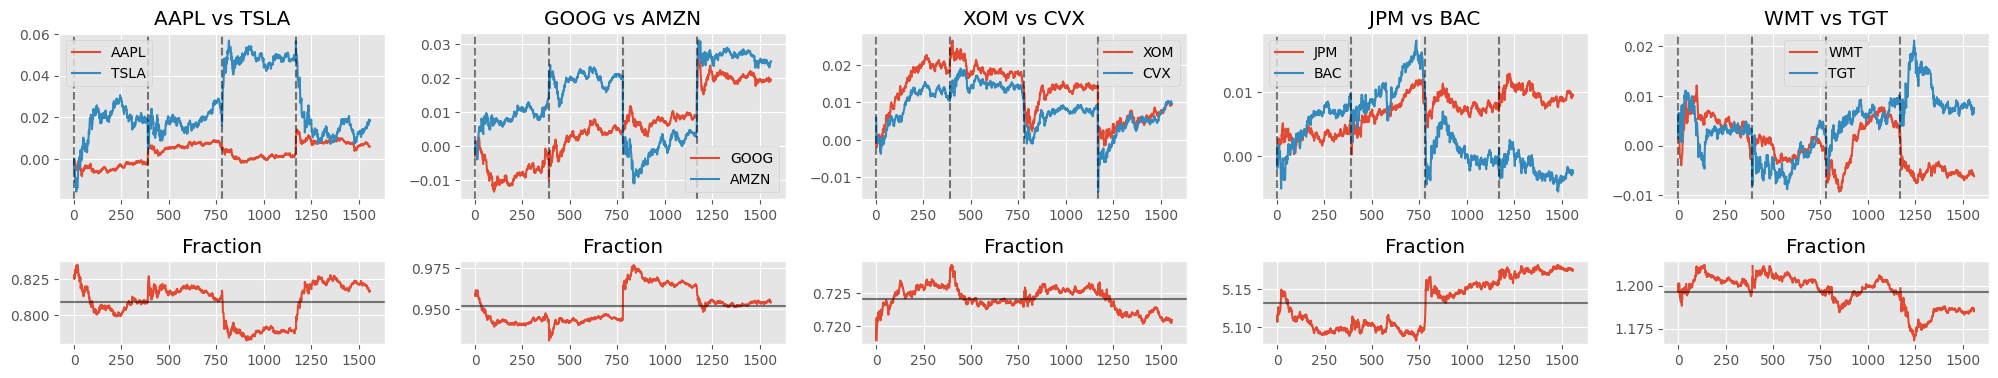

In [180]:
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(5, len(pairs_ts), height_ratios=[2, 1, 1, 1, 1])  # Added an extra row for the "Fraction" subplot

for count, pair in enumerate(pairs_ts):
    # Main plot
    main_ax = fig.add_subplot(gs[0, count])
    main_ax.plot(pairs_ts[pair][pair[0]].pct_change().cumsum())
    main_ax.plot(pairs_ts[pair][pair[1]].pct_change().cumsum())
    for i in range(0, len(pairs_ts[pair]), 390):
        main_ax.axvline(x=i, color="black", linestyle="--", alpha=0.5)
    main_ax.set_title(f"{pair[0]} vs {pair[1]}")
    main_ax.legend([pair[0], pair[1]])

    # Fraction subplot
    fraction_ax = fig.add_subplot(gs[1, count])
    fraction_ax.plot(pairs_ts[pair]['Fraction'])
    fraction_ax.axhline(y=pairs_ts[pair]['Fraction'].mean(), color="black", alpha=0.5)
    fraction_ax.set_title('Fraction')
plt.tight_layout()
plt.show()


### Features

In [181]:
vix = yf.download("^VIX", interval="1m")["Adj Close"].to_frame()
vix.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


<Axes: >

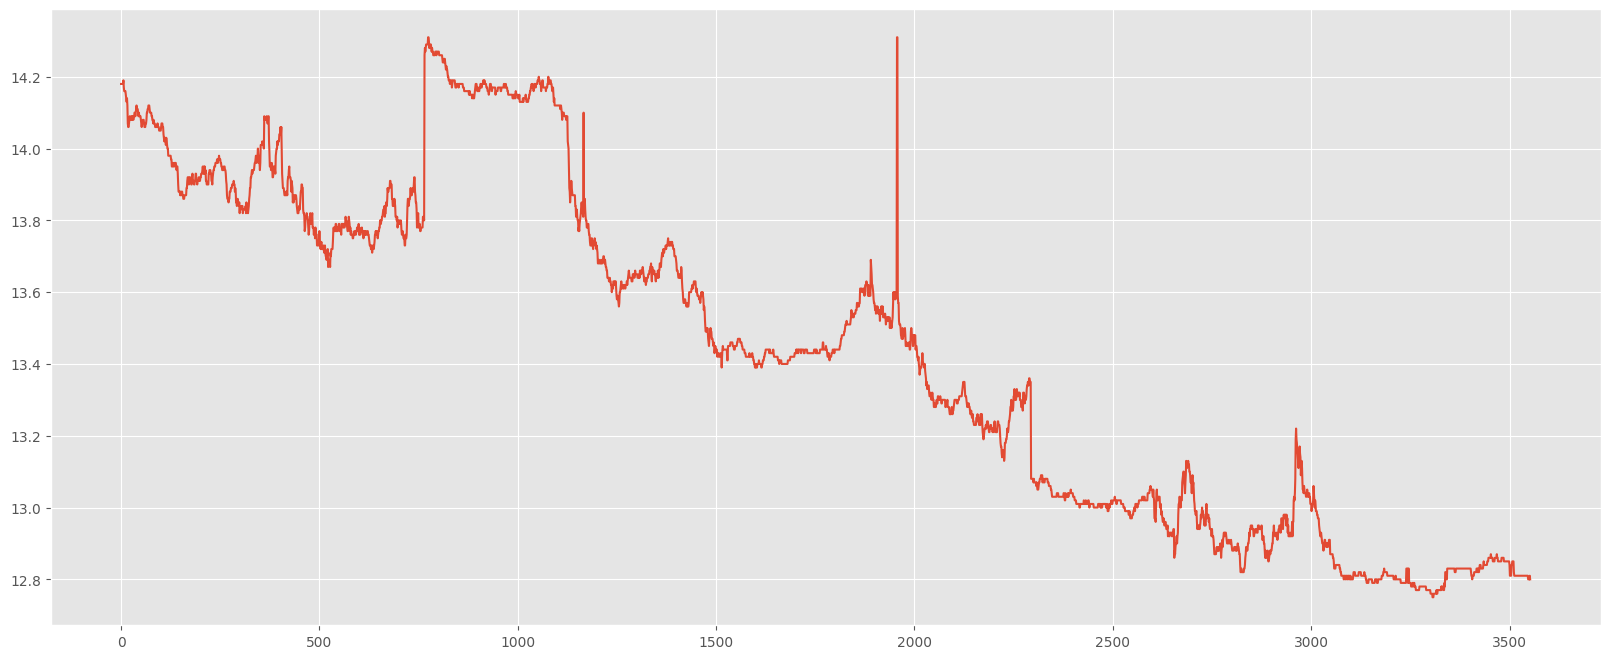

In [182]:
vix["Adj Close"].plot(figsize=(20, 8))

building dataset

In [167]:
for pair in pairs_ts:
    pairs_ts[pair] = pairs_ts[pair].merge(vix, on="Datetime", how="left")
    pairs_ts[pair].rename(columns={"Adj Close": "VIX"}, inplace=True)

In [205]:
for pair in pairs_ts:
    pairs_ts[pair]["prev_day_mean"] = None
    pairs_ts[pair]["crossed_mean"] = None
    for prev_day, day in pairwise(pairs_ts[pair]["Datetime"].dt.date.unique()):
        pairs_ts[pair].loc[pairs_ts[pair]["Datetime"].dt.date == day, "prev_day_mean"] = pairs_ts[pair].loc[pairs_ts[pair]["Datetime"].dt.date == prev_day, "Fraction"].mean()
        # check if price movement crossed the mean (i.e the price went 1 std dev away from the mean and then came back)

        df = pairs_ts[pair].loc[pairs_ts[pair]["Datetime"].dt.date == day]
        has_crossed_mean = False
        has_passed_std = False
        side = None
        for min in df.index:
            if not has_passed_std:
                if df.loc[min, "Fraction"] > df.loc[min, "prev_day_mean"] + 0.1*pairs_ts[pair].loc[:min, "Fraction"].std() or\
                    df.loc[min, "Fraction"] < df.loc[min, "prev_day_mean"] - 0.1*pairs_ts[pair].loc[:min, "Fraction"].std():
                    has_passed_std = True
                    print(f"Passed std at {min}")
                    side = "short" if df.loc[min, "Fraction"] > df.loc[min, "prev_day_mean"] else "long"
                    continue
            elif has_passed_std and not has_crossed_mean:
                if side == "short" and df.loc[min, "Fraction"] < df.loc[min, "prev_day_mean"]:
                    has_crossed_mean = True
                    pairs_ts[pair].loc[min, "crossed_mean"] = True
                elif side == "long" and df.loc[min, "Fraction"] > df.loc[min, "prev_day_mean"]:
                    pairs_ts[pair].loc[min, "crossed_mean"] = True
            if has_crossed_mean and has_passed_std:
                pairs_ts[pair].loc[min, "crossed_mean"] = True
            else:
                pairs_ts[pair].loc[min, "crossed_mean"] = False
        
    # drop the first day
    # pairs_ts[pair] = pairs_ts[pair].iloc[390:, :]
            

Passed std at 390
Passed std at 782
Passed std at 1171
Passed std at 390
Passed std at 780
Passed std at 1170
Passed std at 390
Passed std at 780
Passed std at 1170
Passed std at 390
Passed std at 780
Passed std at 1170
Passed std at 390
Passed std at 780
Passed std at 1170


In [206]:
pairs_ts[pairs[0]].crossed_mean.unique()

array([None, False], dtype=object)

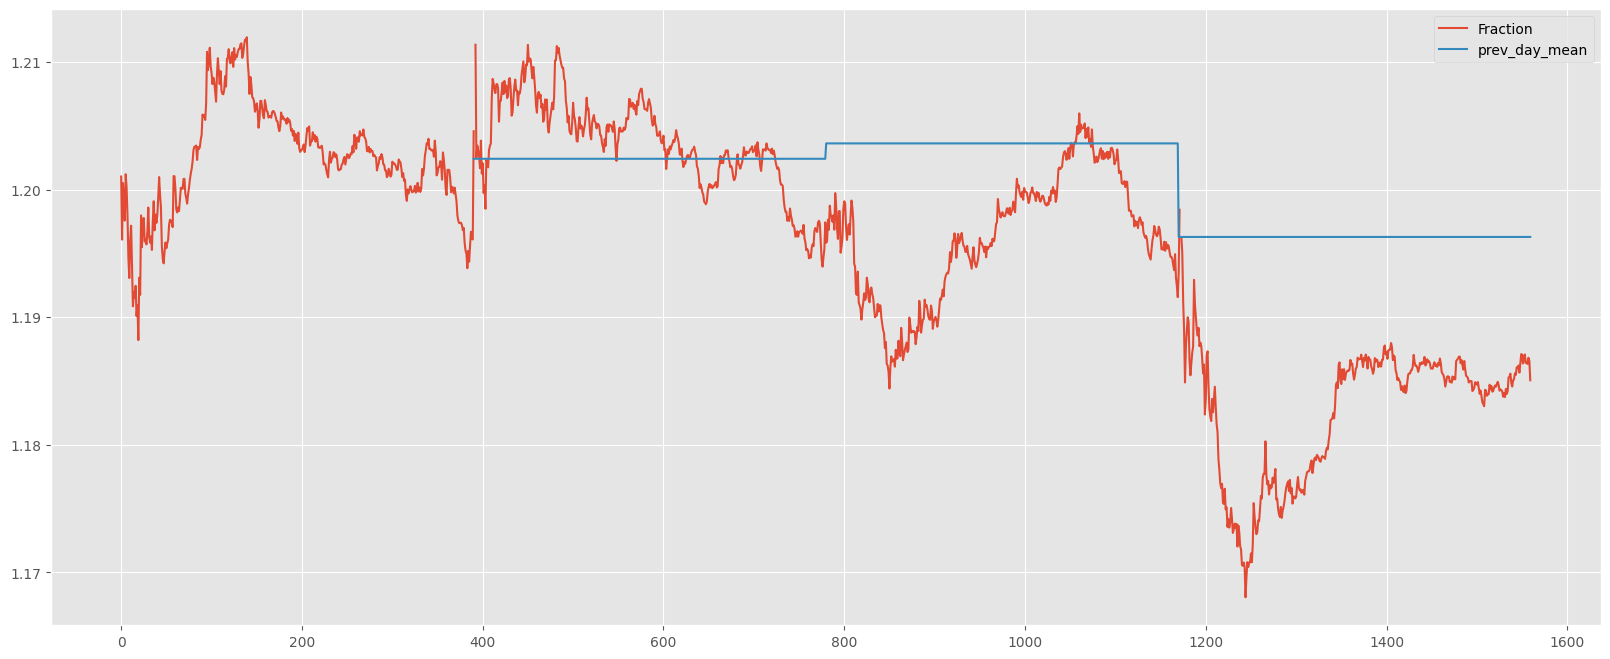

In [198]:
pairs_ts[pairs[4]][["Fraction", "prev_day_mean"]].plot(figsize=(20, 8))
#color days where the price crossed the mean using avxspan
for day in pairs_ts[pairs[1]].index:
    if (day ==0 or day %390 == 0) and pairs_ts[pairs[1]].loc[day, "crossed_mean"]:
        plt.axvspan(day, day + 390, color="green", alpha=0.2)

<Axes: >

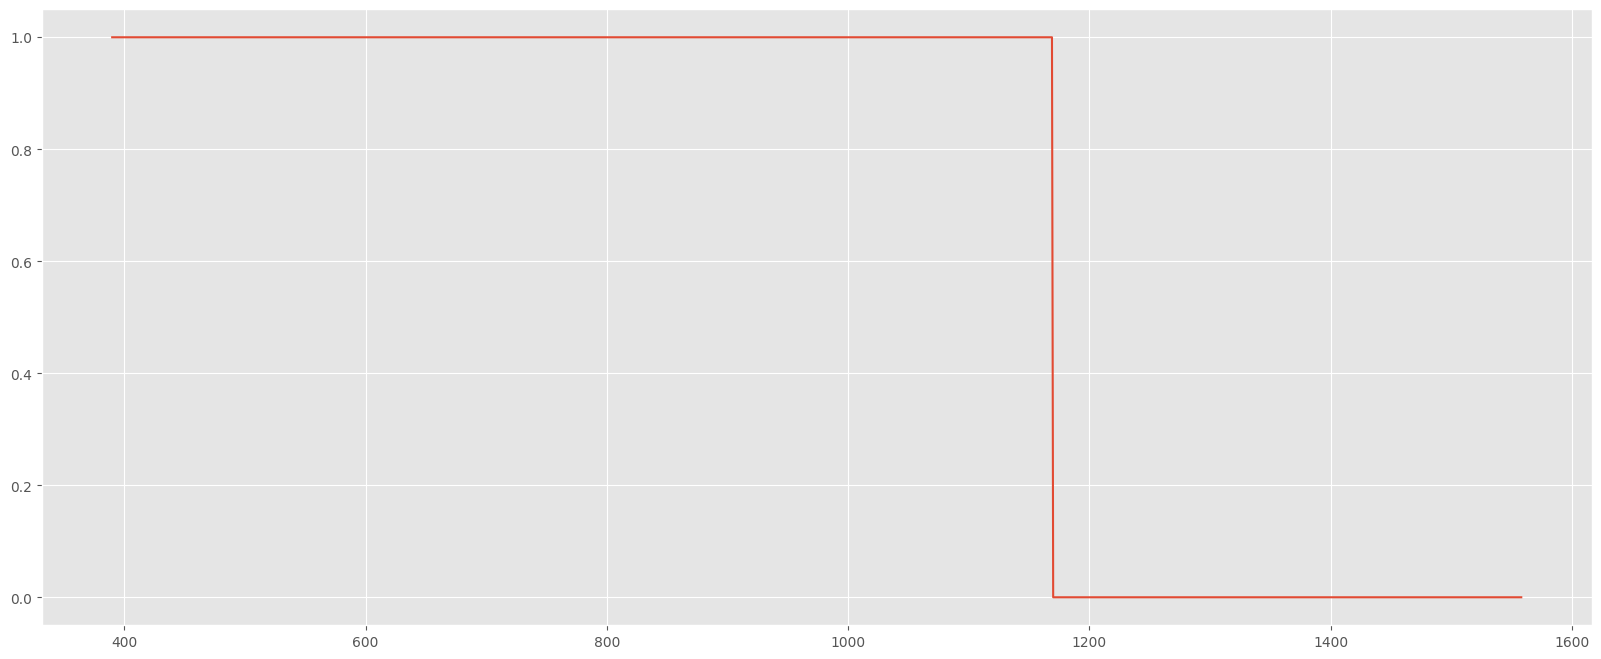

In [122]:
pairs_ts[pair].crossed_mean.astype(int).plot(figsize=(20, 8))

In [ ]:
set().add